# Расчеты для калибровки

## Нефть: 
себестоимость (рублей за тонну) от Росстата, курс доллара, стоимость URALS, прогнозы по добыче, прогноз по издержкам

In [17]:
import os
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
import numpy as np
from requests import get
project_dir = os.getenv('project_dir')

Источник: издержки нефти в рублях по кварталам https://rosstat.gov.ru/folder/11189 раздел энергоэффективность, себестоимость добычи нефти (за тонну)

In [375]:
oil_costs = pd.read_excel(os.path.join(project_dir, 'assets', 'oil_costs.xls'), sheet_name=1, skiprows=2)[:4]
oil_costs = oil_costs.set_index(oil_costs.columns[0]).iloc[:, 6:].ffill()

In [376]:
barell_per_tonn = 7.28

In [377]:
oil_costs = oil_costs/barell_per_tonn

In [378]:
oil_costs

,2018,2019,2020,2021,2022
Unnamed: 0,,,,,
I квартал,1760.049483,2025.776936,1808.035714,2460.934066,4549.925325
II квартал,2029.176438,2149.241494,1269.927198,2799.310300,3458.337912
III квартал,2193.758878,1972.633732,1738.545330,2935.071192,2950.236952
IVквартал,2023.829004,2047.731502,1828.442445,3174.226044,2950.236952


Курс доллара ЦБ

In [381]:

response = get('https://cbr.ru/scripts/XML_dynamic.asp?date_req1=01/01/2018&date_req2=31/12/2022&VAL_NM_RQ=R01235')

In [382]:
dollar = pd.read_xml(response.text)
dollar['Date'] = pd.to_datetime(dollar['Date'], format='%d.%m.%Y')
dollar['Value'] = dollar['Value'].str.replace(',', '.').astype(float)
print(dollar.head())


        Date      Id  Nominal    Value
0 2018-01-10  R01235        1  57.0463
1 2018-01-11  R01235        1  56.8734
2 2018-01-12  R01235        1  56.9957
3 2018-01-13  R01235        1  56.6019
4 2018-01-16  R01235        1  56.3569


In [383]:
dollar.groupby(dollar['Date'].dt.to_period('Q'))['Value'].mean()

Date
2018Q1    56.814870
2018Q2    61.913007
2018Q3    65.551482
2018Q4    66.517628
2019Q1    65.742958
2019Q2    64.521744
2019Q3    64.593618
2019Q4    63.744886
2020Q1    66.626266
2020Q2    72.047914
2020Q3    73.568783
2020Q4    76.203011
2021Q1    74.368552
2021Q2    74.293576
2021Q3    73.470935
2021Q4    72.654305
2022Q1    87.347863
2022Q2    66.514140
2022Q3    59.478273
2022Q4    62.693697
Freq: Q-DEC, Name: Value, dtype: float64

In [384]:
dollar_quarter = np.array(dollar.groupby(dollar['Date'].dt.to_period('Q'))['Value'].mean()).reshape(4, -1, order='F')

In [385]:
cost_usd_per_barell = (oil_costs/dollar_quarter).mean(axis=0)

In [386]:
cost_usd_per_barell

2018    31.911242
2019    31.696734
2020    23.097263
2021    38.602069
2022    50.185905
dtype: float64

средняя цена минфин https://minfin.gov.ru/ru/press-center/?id_4=38298-o_srednei_tsene_na_neft_i_eksportnoi_poshline

In [393]:
oil_prices = pd.Series([70.01, 63.59, 41.73, 69.0, 76.09], index = range(2018, 2023))

In [1059]:
us_inflation= pd.Series([1., 1.0181, 1.0244,  1.0123, 1.0470], index = range(2018, 2023)).cumprod()

In [1076]:
oil_prices

2018    70.01
2019    63.59
2020    41.73
2021    69.00
2022    76.09
dtype: float64

In [1075]:
oil_prices_real = oil_prices/us_inflation

2018    70.010000
2019    62.459483
2020    40.011827
2021    65.355155
2022    68.835371
dtype: float64

прогноз IEA 2020 dollars

https://www.eia.gov/outlooks/aeo/data/browser/#/?id=12-AEO2022&region=0-0&cases=ref2022~highprice~lowprice&start=2020&end=2050&f=A&linechart=~~~ref2022-d011222a.3-12-AEO2022~highprice-d011222a.3-12-AEO2022~lowprice-d011222a.3-12-AEO2022&sourcekey=0

In [1087]:
oil_price_projections_df = pd.read_csv(os.path.join(project_dir, 'assets', 'Real_Petroleum_Prices_Crude_Oil_Brent_Spot.csv'), skiprows=4)

In [1088]:
oil_scenarios = {"mid":"Reference case 2021 $/b", "high":"High oil price 2021 $/b", "low":"Low oil price 2021 $/b"}

In [1923]:
oil_scenario = "high"

In [1924]:
if oil_scenario == 'price_cap':
    
    oil_price_projections_discounted = pd.Series(np.repeat(60/us_inflation.loc[2022], 2051-2018-len(oil_prices)), index=range(2023, 2051))
else:
    rus_oil_discount = 0.98
    oil_price_projections_discounted = rus_oil_discount*pd.Series(oil_price_projections_df[oil_scenarios[oil_scenario]].tolist(), 
                                  index = oil_price_projections_df['Year']).dropna().sort_index()/us_inflation.loc[2021]
    oil_price_projections_discounted = oil_price_projections_discounted.loc[2023:]

In [1925]:
oil_prices_normalized = np.concatenate([np.array(oil_prices), 
                                   np.array(oil_price_projections_discounted), 
                                   np.repeat(oil_price_projections_discounted.iloc[-1], MAX_TIME+2018-2051)])/oil_prices.iloc[0]

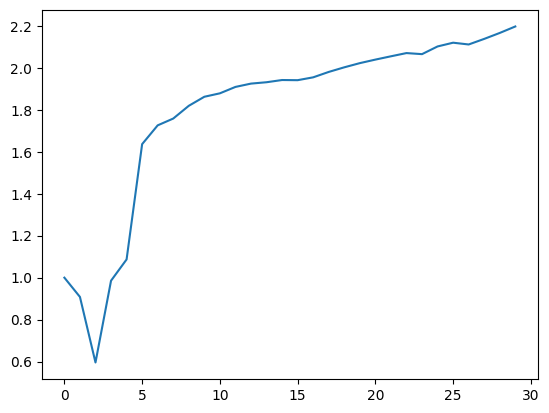

In [1926]:
plt.plot(oil_prices_normalized[:30])

In [1927]:
cost_usd_normalized = cost_usd_per_barell/oil_prices.iloc[0]

In [1928]:
cost_usd_normalized

2018    0.455810
2019    0.452746
2020    0.329914
2021    0.551379
2022    0.716839
dtype: float64

добыча нефти в тоннах в 2018 - 2022

добыча в рублях в 2018

In [1929]:
oil_production_initial = 21499.4

In [1930]:
oil_production = np.array([555.8, 560.2, 518, 523, 535])

In [1931]:
oil_production*7.28

array([4046.224, 4078.256, 3771.04 , 3807.44 , 3894.8  ])

In [1932]:
rub_per_barell = oil_production_initial/(oil_production[0]*7.28)

In [1933]:
oil_production_rub_history = oil_production/oil_production[0]*oil_production_initial

МЭР: прогнозы темпов роста до 2036

In [1934]:
stable_growth = 1.

In [1935]:
oil_production_growth = np.array([1.02]*2 + [0.99]*6 + [1.]*6 +[stable_growth]*10)

Сглаживаем прогнозы МЭР и продляем 

In [1936]:
f = np.poly1d(np.polyfit(np.arange(2023, 2047), oil_production_growth, 4))

In [1937]:
y= 2041

In [1938]:
oil_production_growth_smoothed = np.concatenate([f(np.arange(2023, y)), np.repeat(stable_growth, MAX_TIME-(y-2018))])

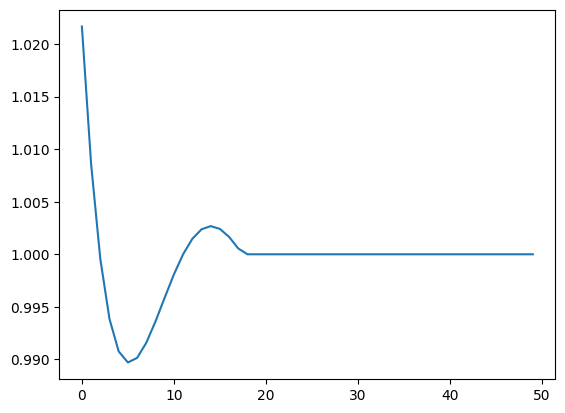

In [1939]:
plt.plot(oil_production_growth_smoothed[:50])

Получаем потенциальную добычу

In [1940]:
oil_production_rub = np.concatenate([oil_production_rub_history, oil_production_rub_history[-1]*oil_production_growth_smoothed.cumprod()])

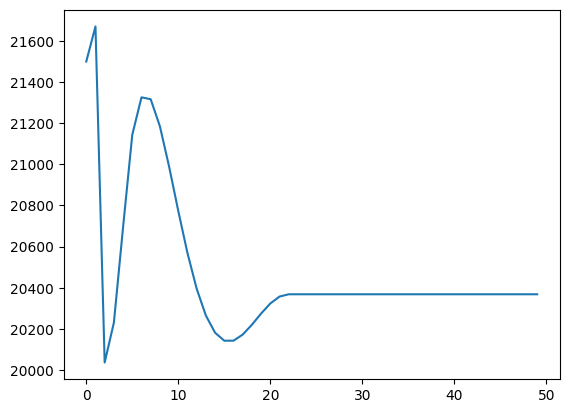

In [1941]:
plt.plot(oil_production_rub[:50])

запасы нефти разведанные: 80 billoins barrels
https://asb.opec.org/ASB_Charts.html?chapter=223

оценка BP
107200 млрд баррелей

In [1942]:
reserves_initial =107200

In [1943]:
reserves_initial_rub = reserves_initial*rub_per_barell

In [1944]:
reserves_initial_rub

569601.6038657277

In [1945]:
last_extraction_year = np.where(reserves_initial_rub>oil_production_rub.cumsum())[0][-1]

In [1946]:
last_year_production = (reserves_initial_rub-oil_production_rub.cumsum())[last_extraction_year]

учтем в производстве истощение запасов

In [1947]:
oil_production_rub_adjusted = np.concatenate([oil_production_rub[:last_extraction_year+1],[last_year_production],[0]*(MAX_TIME- last_extraction_year-2)])

пусть издержки также растут в зависимости от доли извлеченной доли запасов

In [1948]:
extracted = oil_production_rub_adjusted.cumsum()/reserves_initial_rub

In [1949]:
cost_usd_normalized

2018    0.455810
2019    0.452746
2020    0.329914
2021    0.551379
2022    0.716839
dtype: float64

In [1950]:
def get_costs(extracted):
    return 0.46 + 0.92* extracted

In [1951]:
costs = [get_costs(i) for i in extracted]

In [1952]:
costs[:5] = cost_usd_normalized

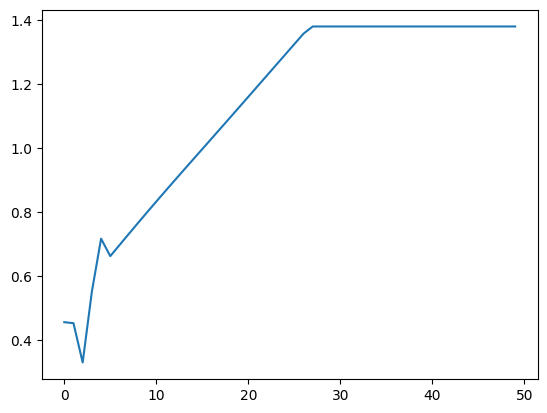

In [1953]:
plt.plot(costs[:50])

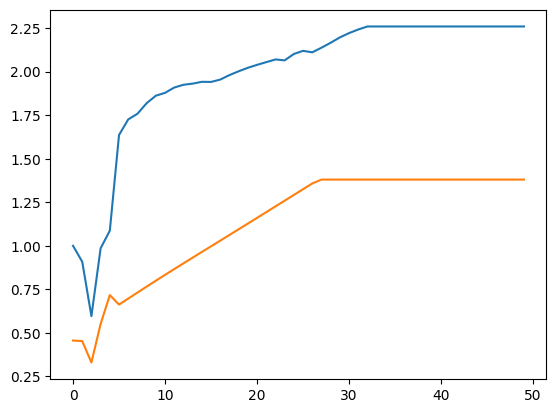

In [1954]:
plt.plot(oil_prices_normalized[:50])
plt.plot(costs[:50])

In [1955]:
unprofitable_year  = np.where(oil_prices_normalized<costs)[0][0] if len(np.where(oil_prices_normalized<costs)[0]) > 0 else MAX_TIME

In [1956]:
oil_production_rub_adjusted[unprofitable_year:] = 0

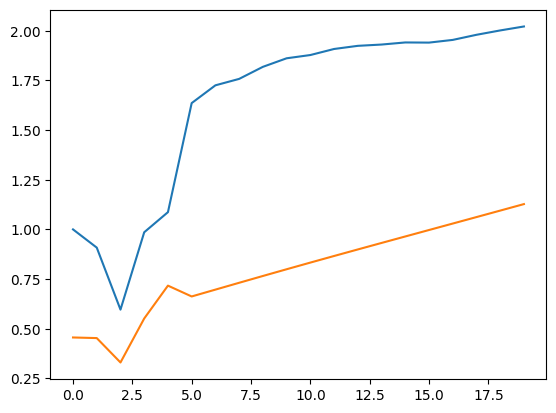

In [1957]:
plt.plot(oil_prices_normalized[:20])
plt.plot(costs[:20])

In [1958]:
oil = {'Y_O':oil_production_rub_adjusted, 'price_O':oil_prices_normalized, 'psi_O':costs}

In [1959]:
import pickle
with open(os.path.join(project_dir,'assets', f'oil_{oil_scenario}.pickle'), 'wb') as f:
    pickle.dump(oil, f,protocol = pickle.HIGHEST_PROTOCOL)

## Демография
прогноз ООН
https://population.un.org/wpp/Download/Standard/Population/


Исходные данные:
- population (rows=years, columns=ages)
- mortality 
- fertility
- life expectancy
- Pi

переводим в тензор размера:

$$ (2, \hat{T}+G_{total}+G_{model}, \hat{T}+G_{total})$$

где $\hat{T}= 500$ (максимальный индекс времени, не совпадает со временем до достижения устойчивого состояния)

$G_{total} = 101$ (количество поколений по населению)

$G_{model} = 80$ (агенты с 20 лет)

возраст выхода с рынка труда J рассчитан в assets/возраст здоровой жизни, для поколения 1957 г.р. он равен 61 год, далее должен расти пропорционально ожидаемой продолжительности жизни

In [314]:
import matplotlib.pyplot as plt

In [439]:
G_TOTAL = int(os.getenv('G_TOTAL'))
MAX_TIME = int(os.getenv('MAX_TIME'))
# SIMULATION_TIME = MAX_TIME-G_TOTAL
G_MODEL = 80
base_year = 2018
un_max_year = 2100
J_1957 = 61

In [344]:
population_scenarios = ('Medium variant', 'High variant', 'Low variant')
scenario = population_scenarios[2]
scenario.lower().split(' ')[0]
sexes = ('FEMALE', 'MALE')
sex_ids = (3, 2)
sex = sexes[0]
sex_id = sex_ids[0]

историческая ожидаемая продолжительность жизни (г.р. до 2021)

In [345]:
def get_un_prospect(fname, sheet_name):
    return pd.read_excel(os.path.join(project_dir,
                                     'assets', f'{fname}.xlsx'),
                        skiprows=16,
                        sheet_name = sheet_name).query("`Location code`==643")

Население по возрастам в каждый момент времени

In [346]:
population = {}
for sex, sex_id in zip(sexes, sex_ids):
    population_history = get_un_prospect(fname = f'WPP2022_POP_F01_{sex_id}_POPULATION_SINGLE_AGE_{sex}', sheet_name = 'Estimates')
    population_forecast = get_un_prospect(fname = f'WPP2022_POP_F01_{sex_id}_POPULATION_SINGLE_AGE_{sex}', sheet_name = scenario)
    population[sex] = pd.concat([population_history,population_forecast]).iloc[:,10:].sort_values('Year').set_index('Year')

In [347]:
female_ratio = population['FEMALE'][0]/(population['FEMALE'][0]+population['MALE'][0])

In [348]:
deaths = {}
for sex, sex_id in zip(sexes, sex_ids):
    history_death = get_un_prospect(fname = f'WPP2022_MORT_F01_{sex_id}_DEATHS_SINGLE_AGE_{sex}', sheet_name = 'Estimates')
    forecast_death = get_un_prospect(fname = f'WPP2022_MORT_F01_{sex_id}_DEATHS_SINGLE_AGE_{sex}', sheet_name = scenario)
    deaths[sex] = pd.concat([history_death, forecast_death]).iloc[:,10:].sort_values('Year').set_index('Year')

In [349]:
mortality = {}
for sex in sexes:
    mortality[sex] = deaths[sex]/population[sex]

In [350]:
survival_probability = {}
life_expectancy = {}
exit_age = {}
for sex in sexes:
    survival_probability[sex] = (1-mortality[sex]).cumprod(axis=1)
    survival_probability[sex].iloc[:,-1] = 0
    life_expectancy[sex] = pd.DataFrame((np.array((1- mortality[sex]).cumprod(axis=1).iloc[:,:-1])*\
                                    np.array(mortality[sex].iloc[:,1:]*np.arange(1,101))).sum(axis=1)).set_index(mortality[sex].index)
    exit_age_to_life_expectancy = J_1957/life_expectancy[sex].loc[1957].squeeze()
    exit_age[sex] = np.floor(exit_age_to_life_expectancy*life_expectancy[sex])

In [351]:
history_births = get_un_prospect(fname = f'WPP2022_FERT_F03_BIRTHS_BY_SINGLE_AGE_OF_MOTHER', sheet_name = 'Estimates')
forecast_births = get_un_prospect(fname = f'WPP2022_FERT_F03_BIRTHS_BY_SINGLE_AGE_OF_MOTHER', sheet_name = scenario)
births_total = pd.concat([history_births, forecast_births]).iloc[:,10:].sort_values('Year').set_index('Year')

In [352]:
births = {}
births['FEMALE'] = (np.array(female_ratio)*births_total.transpose()).transpose()
births['MALE'] = (np.array(1-female_ratio)*births_total.transpose()).transpose()

In [353]:
fertility = {}
for sex in sexes:
    fertility[sex] = births[sex]/population['FEMALE'].loc[:,15:49]

In [354]:
births_yearly = {}
births_yearly['FEMALE'] = births_total.sum(axis=1)*female_ratio
births_yearly['MALE'] = births_total.sum(axis=1)*(1-female_ratio)

Оцениваем миграцию по рождениям и смертям (только с 1951 года)

In [355]:
migration = {}
for sex in sexes:
    zero_migration_population = np.concatenate((np.array(births_yearly[sex])[1:].reshape(-1,1),
                                                np.array(population[sex] - deaths[sex])[:-1,:-1]), axis=1)
    migration_array = np.array(population[sex])[1:] - zero_migration_population
    migration_array = np.vstack([migration_array, migration_array[-1]])
    migration_array[:, -1] = 0
    migration[sex] = pd.DataFrame(migration_array).set_index(population[sex].index)
    migration[sex].columns = population[sex].iloc[1:].columns

In [356]:
migration_rate = {}
for sex in sexes:
    migration_rate[sex] = (migration[sex].transpose()/(population['FEMALE']+population['MALE']).sum(axis=1)).transpose()

In [415]:
demography = {name:np.zeros((2, MAX_TIME+G_TOTAL, MAX_TIME)) 
              for name in ('population', 'deaths', 'mortality', 'births', 'fertility', 'migration', 'migration_rate', 'survival_probability', 'epsilon', 'rho', 'rho_reform')}

## прогноз оон

In [416]:
for sex_id, sex in enumerate(('FEMALE', 'MALE')):
    for year in range(base_year, un_max_year+1):
        year_idx = year - base_year
        demography['population'][sex_id,year_idx:(year_idx+G_TOTAL),  year_idx] = population[sex].loc[year].tolist()[::-1]
        
        demography['deaths'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx] = deaths[sex].loc[year].tolist()[::-1]
        demography['mortality'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx] = mortality[sex].loc[year].tolist()[::-1]
        
        demography['births'][sex_id, (year_idx+(G_TOTAL-50)):(year_idx+G_TOTAL-15), year_idx] = births[sex].loc[year].tolist()[::-1]
        demography['fertility'][sex_id, (year_idx+(G_TOTAL-50)):(year_idx+G_TOTAL-15), year_idx] = fertility[sex].loc[year].tolist()[::-1]
        
        demography['migration'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx] = migration[sex].loc[year].tolist()[::-1]
        demography['migration_rate'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx] = migration_rate[sex].loc[year].tolist()[::-1]
        
        demography['survival_probability'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx] = survival_probability[sex].loc[year].tolist()[::-1]
        
        
    np.fill_diagonal(demography['mortality'][sex_id], 1)

## постпрогнозный период (стационарные смертность, рождаемость, миграция)

In [418]:
for sex_id, sex in enumerate(('FEMALE', 'MALE')):
    for year in range(un_max_year+1, MAX_TIME+base_year):
        stationary_year = un_max_year-base_year
        year_idx = year - base_year
        for ratio in ('mortality', 'fertility', 'migration_rate', 'survival_probability'):
            demography[ratio][sex_id, year_idx:(year_idx+G_TOTAL), year_idx] = \
                demography[ratio][sex_id, stationary_year:(stationary_year+G_TOTAL), stationary_year]
        
        
        
        demography['population'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx] = \
            demography['population'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx-1]*\
            (
                1 - demography['mortality'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx-1]
            ) +\
            (
                demography['migration_rate'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx-1]*\
                demography['population'][:, :, year_idx-1].sum()
            )
        
        demography['population'][sex_id, year_idx+G_TOTAL-1, year_idx] += \
            (demography['fertility'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx-1]*\
            demography['population'][0, year_idx:(year_idx+G_TOTAL), year_idx-1]).sum()
            
        demography['deaths'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx] = \
            demography['population'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx-1]*\
                demography['mortality'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx-1]
                
        demography['births'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx] =\
            demography['fertility'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx-1]*\
            demography['population'][0, year_idx:(year_idx+G_TOTAL), year_idx-1]
        
        demography['migration'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx] =\
            demography['migration_rate'][sex_id, year_idx:(year_idx+G_TOTAL), year_idx-1]*\
            (demography['population'][:, :, year_idx-1].sum())

производительность труда, пенсионный возраст

In [419]:
age_specific_labor_efficiency = {'MALE': np.array([0.025, -0.00036]), "FEMALE": np.array([0.039, -0.00043])}

In [420]:
retirement_age = {'MALE': 60, "FEMALE": 55}

In [421]:
retirement_age_reform = {'MALE': [(year_of_birth, age) for year_of_birth, age in zip(range(1958,1964), (60, 60.5, 61.5, 63, 64, 65))] ,
                         "FEMALE": [(year_of_birth, age) for year_of_birth, age in zip(range(1963,1969), (55, 55.5, 56.5, 58, 59, 60))]}

In [430]:
for sex_id, sex in enumerate(('FEMALE', 'MALE')):
    for g in range(MAX_TIME+G_TOTAL):
        
        birth_year = base_year - G_TOTAL + g+1
        
        exit_idx = min(max(birth_year, exit_age[sex].index.min()), exit_age[sex].index.max())
        
        age = G_TOTAL-g-1
        
        exit_age_g =  exit_age[sex].loc[exit_idx].squeeze()
        
        remain_years = (max(0, birth_year-base_year), min(g+1, MAX_TIME))
        remain_length = remain_years[1]-remain_years[0]
        
        age_specific_epsilon = [np.exp(np.dot(age_specific_labor_efficiency[sex],np.array([age, age**2])))
               if age >= 20 and age <= exit_age_g else 0 for age in range(G_TOTAL)]
        
        age_specific_rho = [1 if age >= retirement_age[sex] else 0 for age in range(G_TOTAL)]
        
        if birth_year <= retirement_age_reform[sex][0][0]:
            age_specific_rho_reform = age_specific_rho
        elif birth_year >= retirement_age_reform[sex][-1][0]:
            age_specific_rho_reform = [1 if age >= retirement_age_reform[sex][-1][1] else 0 for age in range(G_TOTAL)]
        else:
            retirement_age_g = [age for year, age in retirement_age_reform[sex] if birth_year==year][0]
            if isinstance(retirement_age_g, int):
                age_specific_rho_reform = [1 if age >= retirement_age_g else 0 for age in range(G_TOTAL)]
            else:
                age_specific_rho_reform = [0.5 if age == retirement_age_g else 1 if age > retirement_age_g else 0 for age in range(G_TOTAL)]
        if remain_length > 0:
            
            demography['epsilon'][sex_id, g, remain_years[0]:remain_years[1]] = age_specific_epsilon[-remain_length:]

            demography['rho'][sex_id, g, remain_years[0]:remain_years[1]] = age_specific_rho[-remain_length:]

            demography['rho_reform'][sex_id, g, remain_years[0]:remain_years[1]] = age_specific_rho_reform[-remain_length:]
        

In [431]:
import pickle
with open(os.path.join(project_dir,'assets', f'demography_{scenario.lower().split(" ")[0]}.pickle'), 'wb') as f:
    pickle.dump(demography, f,protocol = pickle.HIGHEST_PROTOCOL)

In [1659]:
population_scenarios = ('Medium variant', 'High variant', 'Low variant')

NameError: name 'scenarios' is not defined

In [1664]:
scenario='High variant'

In [1665]:
with open(os.path.join(project_dir,'assets', f'demography_{scenario.lower().split(" ")[0]}.pickle'), 'rb') as f:
    dem = pickle.load(f)

In [1666]:
dem['population'][:, :, 72].sum()

155062.37199999997

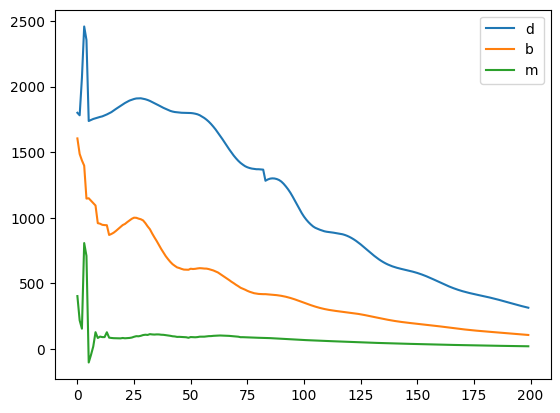

In [432]:
# plt.plot(demography['births'][0].sum(axis=1)[:200], label='b')
plt.plot(demography['deaths'].sum(axis=0).sum(axis=0)[:200], label='d')
plt.plot(demography['births'].sum(axis=0).sum(axis=0)[:200], label='b')
plt.plot(demography['migration'].sum(axis=0).sum(axis=0)[:200], label='m')
plt.legend()

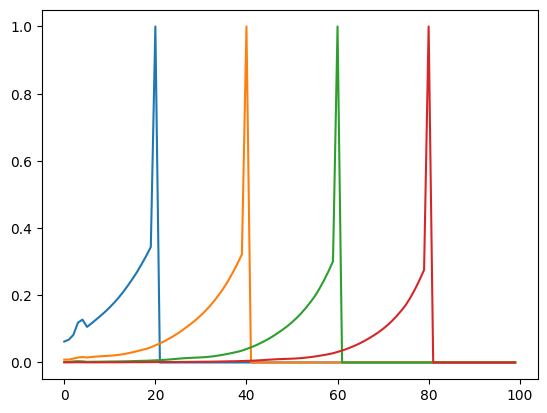

In [433]:
plt.plot(demography['mortality'][0, 20, :100])
plt.plot(demography['mortality'][0, 40, :100])
plt.plot(demography['mortality'][0, 60, :100])
plt.plot(demography['mortality'][0, 80, :100])

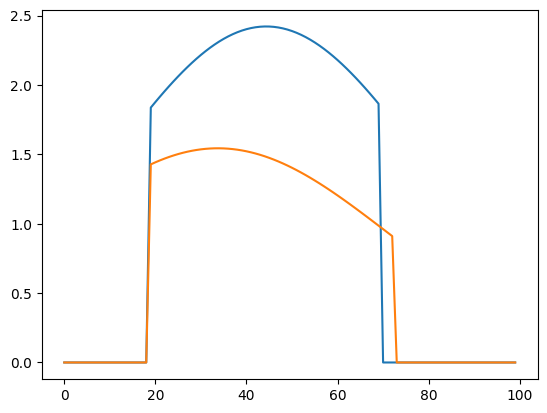

In [434]:
plt.plot(demography['epsilon'][0, 100:200, 100][::-1])
plt.plot(demography['epsilon'][1, 100:200, 100][::-1])

# ВВП, капитал

In [1961]:
Y_non_oil = 103861.-21499.4

In [1972]:
20387/(Y_non_oil/(0.14/0.35))

0.09901216100707128

In [1976]:
K = Y_non_oil/(0.14/0.35)

In [1977]:
K

205903.99999999997

labor

In [1979]:
1/(K**0.35/ Y_non_oil)**(1/0.65) 

50286.26568021161

In [1980]:
50286**0.65 * K**0.35

82361.31715509761

In [ ]:
Y_non_oil

In [ ]:
1/((1 - 1.5/2 * (1.02*0.98 -1)**2
                          - 1.5*self.A_growth*self.N_growth * (self.A_growth*self.N_growth -1))+
                         self.psi/(1+self.r[self.T+1]) * (self.A_growth*self.N_growth -1)* (self.A_growth*self.N_growth)**2)